In [6]:
import trimesh
import numpy as np

import os
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.spatial.transform import Rotation as R
import time
import pickle
import argparse
from utils import *
import matplotlib 
from matplotlib import pyplot as plt
from tqdm import tqdm
from deepVCP import DeepVCP

In [7]:
src_pts = trimesh.load('./meshes/bun000_v2.ply')

In [8]:
def cal_boundinbox_len(model):
    x_len = np.amax(model[:,0]) - np.amin(model[:,0])
    y_len = np.amax(model[:,1]) - np.amin(model[:,1])
    z_len = np.amax(model[:,2]) - np.amin(model[:,2])
    diag_len_bounding_box = np.sqrt(x_len * x_len + y_len * y_len + z_len * z_len)
    return diag_len_bounding_box

In [9]:
def generate_G_t(model, diag_len_bounding_box):
    theta_x = np.random.uniform(0, np.pi/5)
    theta_y = np.random.uniform(0, np.pi/5)
    theta_z = np.random.uniform(0, np.pi/5)
    
    # generate random translation
    translation_max = diag_len_bounding_box * 0.3
    translation_min = diag_len_bounding_box  * 0.3
    t = np.random.uniform(translation_min, translation_max, (3, 1))
    Rx = RotX(theta_x)
    Ry = RotY(theta_y)
    Rz = RotZ(theta_z)
    R = Rx @ Ry @ Rz
    target_points = R @ model.T + t
    return target_points, R, t

In [10]:
def display2(inputs):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors=['b','r']
    for idx, input in enumerate(inputs):
        ax.scatter(input[:,0], input[:,1], -input[:,2], c=colors[idx], marker='.', s=1)
    plt.show()

In [11]:
src = src_pts.sample(10000)
boundingbox_len = cal_boundinbox_len(src)
targets, R, t = generate_G_t(src, boundingbox_len)

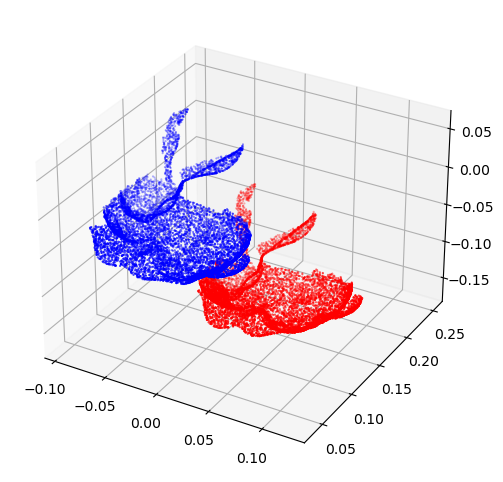

In [12]:
display2([src, targets.T])

In [13]:
src_xyz = torch.from_numpy(src.T).unsqueeze(0).cuda()
target_xyz = torch.from_numpy(targets).unsqueeze(0).cuda()

In [15]:
R_prior = torch.from_numpy(R).cuda()#.unsqueeze(0)
t_init =  torch.randn((1, 3)).cuda()

In [16]:
model = DeepVCP(use_normal=False).cuda()

In [17]:
model.load_state_dict(torch.load('epoch_6_model.pt', map_location='cuda'))

<All keys matched successfully>

In [18]:
model.eval()

DeepVCP(
  (FE1): feat_extraction_layer(
    (sa1): PointNetSetAbstraction(
      (mlp_convs): ModuleList(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (mlp_bns): ModuleList(
        (0-1): 2 x BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (sa2): PointNetSetAbstraction(
      (mlp_convs): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (mlp_bns): ModuleList(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (sa3): PointNetSetAbstraction(

In [34]:
corruption = torch.FloatTensor(1, 3, 3).uniform_(0.7, 1.4).cuda()
R_prior = R_prior*corruption

In [35]:
with torch.no_grad():
    src_keypts, target_vcp = model(src_xyz, target_xyz, R_prior, t_init)

feature extraction time:  13.123998641967773
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.031000137329101562
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([9260, 3401, 7032,  ..., 7269, 1992, 6795], device='cuda:0')
get_cat_feat_tgt time:  0.10099959373474121


In [36]:
target_vcp.shape

torch.Size([1, 64, 3])

In [37]:
src_keypts.shape

torch.Size([1, 64, 3])

In [38]:
extra_model = src.copy()

In [39]:
from deepVCP_loss import get_rigid_transform 

In [40]:
R, t = get_rigid_transform(src_keypts.permute(0,2,1).float(), target_vcp.permute(0,2,1).float())

In [41]:
src_t = torch.matmul(R, src_xyz.float()) + t

In [42]:
src_t = src_t.permute(0,2,1).cpu().numpy()[0].astype(np.float64)

In [43]:
z = np.array(targets.T)

In [44]:
src_t.shape

(10000, 3)

In [45]:
src_t.max()

0.26905500888824463

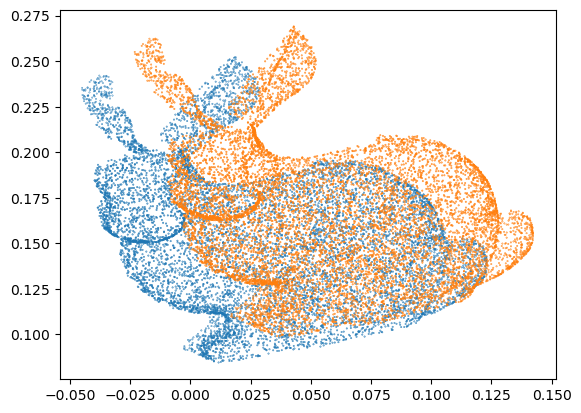

In [46]:
plt.scatter(z[:,0], z[:,1], z[:,2])
plt.scatter(src_t[:,0], src_t[:,1], src_t[:,2])

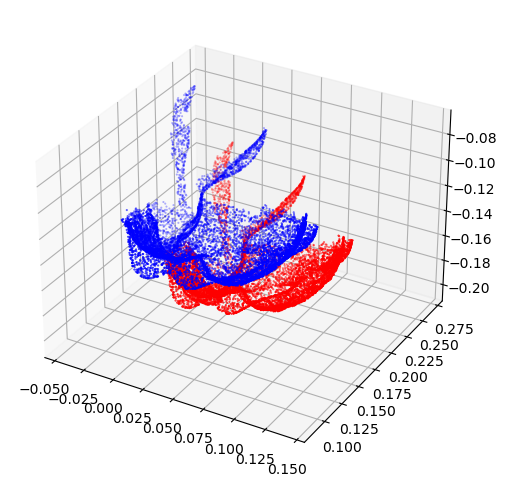

In [47]:
display2([z, src_t])

In [63]:
org = (src_xyz[0].T@R_prior).cpu().numpy()[0]

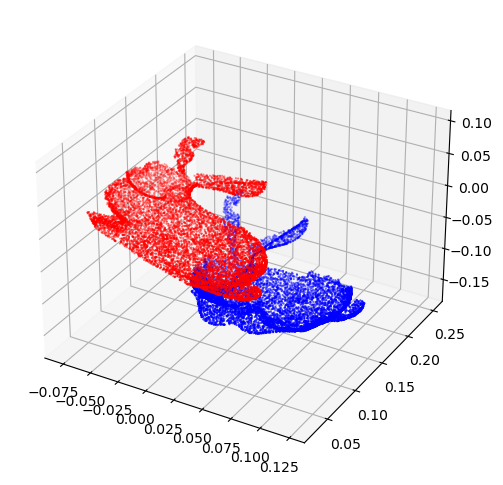

In [64]:
display2([z, org])

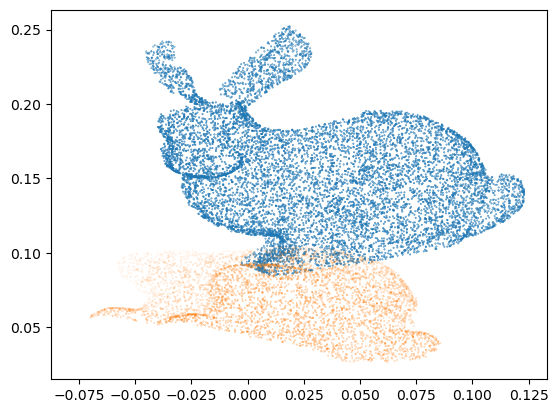

In [65]:
plt.scatter(z[:,0], z[:,1], z[:,2])
plt.scatter(org[:,0], org[:,1], org[:,2])

In [67]:
import numpy as np
from sklearn.neighbors import KDTree


# Point to point ICP- https://en.wikipedia.org/wiki/Iterative_closest_point

def icp(surface_points_1, surface_points_2, max_iterations=30, min_dist=2e-2):
    tree_1 = KDTree(surface_points_1)
    R = None
    t = None
    error = []
    for i in range(max_iterations):
        distances, indices = tree_1.query(surface_points_2, 1)
        error.append(distances.mean())
        matching_indices = distances < min_dist
        p = surface_points_1[indices[matching_indices]].squeeze()
        q = np.expand_dims(surface_points_2, axis=1)[
            matching_indices].squeeze()
        p_mean = np.mean(p, axis=0)
        q_mean = np.mean(q, axis=0)
        p_bar = p - p_mean
        q_bar = q - q_mean
        u, sigma, v_t = np.linalg.svd(np.dot(q_bar.T, p_bar))
        det = np.linalg.det(np.dot(v_t.T, u.T))
        correction = np.eye(3)
        if det < 0:
            correction[2, 2] = -1
        R = np.dot(np.dot(v_t.T, correction), u.T)
        t = p_mean.T - np.dot(R, q_mean.T)
        t = np.expand_dims(t, axis=1)
        surface_points_2 = (np.dot(R, surface_points_2.T) + t).T
    distances, indices = tree_1.query(surface_points_2, 1)
    error.append(np.mean(distances))
    return surface_points_2, error

In [68]:
z.shape

(10000, 3)

In [69]:
org.shape

(10000, 3)

In [71]:
org_t,e = icp(org, z, max_iterations=30, min_dist=2e2)

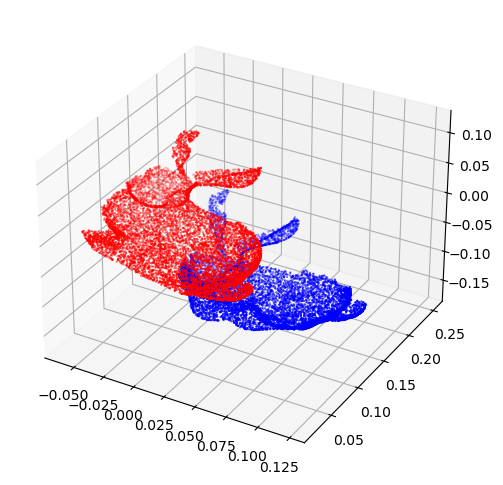

In [72]:
display2([z, org_t])